# Tensorflow Object Detection API 視訊測試

In [1]:
%matplotlib inline
import os
import pathlib
import tensorflow as tf
import pathlib

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
tf.get_logger().setLevel('ERROR')           # Suppress TensorFlow logging (2)

## GPU 記憶體配置設定

In [2]:
# GPU 設定為 記憶體動態調整 (dynamic memory allocation)
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
#  GPU 設定為固定為 2GB 
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*2)])


## 載入模型

In [4]:
# 下載模型，請參考 17_01_Tensorflow_Object_Detection_API_Test.ipynb
# 模型路徑, pathlib.Path.home()：登入的使用者預設目錄
PATH_TO_MODEL_DIR = os.path.join(pathlib.Path.home(), '.keras\\datasets\\centernet_hg104_1024x1024_coco17_tpu-32')
PATH_TO_MODEL_DIR

'C:\\Users\\Chiawei_Chuang\\.keras\\datasets\\centernet_hg104_1024x1024_coco17_tpu-32'

## 載入模型

In [5]:
# 從下載的目錄載入模型另一種方法，非常快速
import time
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

PATH_TO_CFG = PATH_TO_MODEL_DIR + "/pipeline.config"
PATH_TO_CKPT = PATH_TO_MODEL_DIR + "/checkpoint"

print('Loading model... ', end='')
start_time = time.time()

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(PATH_TO_CFG)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(PATH_TO_CKPT, 'ckpt-0')).expect_partial()

# @tf.function
def detect_fn(image):
    """Detect objects in image."""

    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)

    return detections

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model... Done! Took 1.3460330963134766 seconds


## 建立 Label 的對照表

In [6]:
# 下載 labels file，請參考 17_01_Tensorflow_Object_Detection_API_Test.ipynb
# labels file路徑, pathlib.Path.home()：登入的使用者預設目錄
PATH_TO_LABELS = os.path.join(pathlib.Path.home(), '.keras\\datasets\\mscoco_label_map.pbtxt')
PATH_TO_LABELS

'C:\\Users\\Chiawei_Chuang\\.keras\\datasets\\mscoco_label_map.pbtxt'

In [7]:
# 建立 Label 的對照表 (代碼與名稱)
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## 視訊物件偵測

In [8]:
import numpy as np
import cv2

# 使用 webcam
#cap = cv2.VideoCapture(0)

# 讀取視訊檔案
cap = cv2.VideoCapture('./0_video/pedestrians.mp4')
i=0
while True:
    # 讀取一幀(frame) from camera or mp4
    ret, image_np = cap.read()

    # 加一維，變為 (筆數, 寬, 高, 顏色)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)

    # Things to try:
    # Flip horizontally
    # image_np = np.fliplr(image_np).copy()

    # Convert image to grayscale
    # image_np = np.tile(
    #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    # 轉為 TensorFlow tensor 資料型態
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    
    # detections：物件資訊 內含 (候選框, 類別, 機率)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))

    if i==0:
        print(f'物件個數：{num_detections}')
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(int)

    # 第一個 label 編號
    label_id_offset = 1
    
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'] + label_id_offset,
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.30,
          agnostic_mode=False)

    # 顯示偵測結果
    img = cv2.resize(image_np_with_detections, (800, 600))
    cv2.imshow('object detection', img)

    # 存檔
    i+=1
    if i==30:
        cv2.imwrite('./images_2/pedestrians.png', img)
    
    # 按 q 可以結束
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

物件個數：100


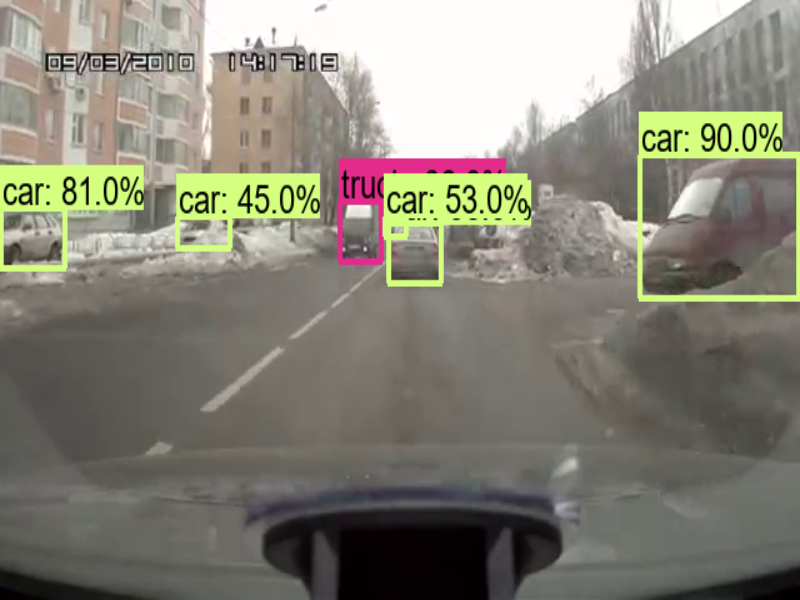

In [11]:
# plt.show()
from IPython.display import Image
Image('./images_2/pedestrians.png')

## 夜晚物件偵測

In [9]:
import numpy as np
import cv2

# # 使用 webcam
# cap = cv2.VideoCapture(0)
# 讀取視訊檔案
cap = cv2.VideoCapture('./0_video/night.mp4')
i=0
while True:
    # 讀取一幀(frame) from camera or mp4
    ret, image_np = cap.read()

    # 加一維，變為 (筆數, 寬, 高, 顏色)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)

    # Things to try:
    # Flip horizontally
    # image_np = np.fliplr(image_np).copy()

    # Convert image to grayscale
    # image_np = np.tile(
    #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    # 轉為 TensorFlow tensor 資料型態
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    
    # detections：物件資訊 內含 (候選框, 類別, 機率)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))

    if i==0:
        print(f'物件個數：{num_detections}')
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(int)

    # 第一個 label 編號
    label_id_offset = 1
    
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'] + label_id_offset,
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.30,
          agnostic_mode=False)

    # 顯示偵測結果
    img = cv2.resize(image_np_with_detections, (800, 600))
    cv2.imshow('object detection', img)

    # 存檔
    i+=1
    if i==30:
        cv2.imwrite('./images_2/night.png', img)
    
    # 按 q 可以結束
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

物件個數：100


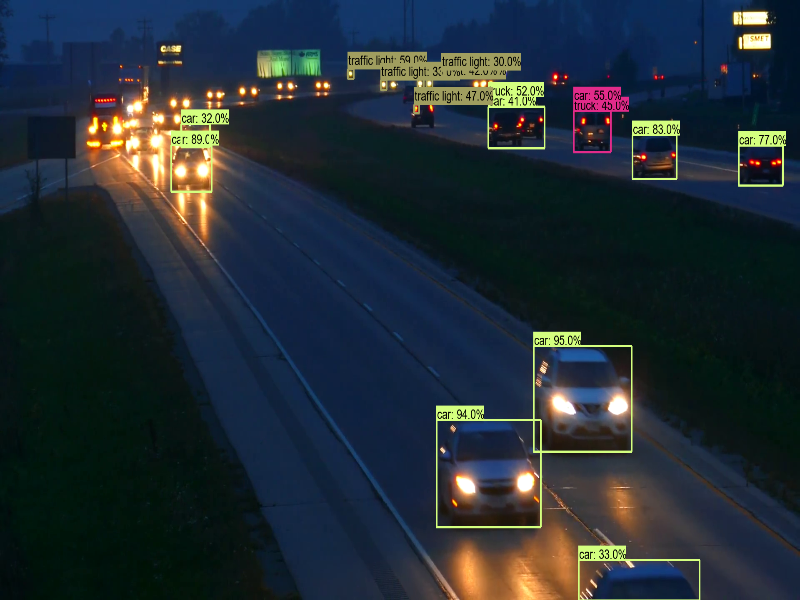

In [10]:
# plt.show()
from IPython.display import Image
Image('./images_2/night.png')